In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [16]:
import os

def get_words_in_file(filename):
    """ Returns a list of all words in the file at filename. """
    with open(filename, 'r', encoding = "ISO-8859-1") as f:
        # read() reads in a string from a file pointer, and split() splits a
        # string into words based on whitespace
        words = f.read().split()
    return words

def get_files_in_folder(folder):
    """ Returns a list of files in folder (including the path to the file) """
    filenames = os.listdir(folder)
    # os.path.join combines paths while dealing with /s and \s appropriately
    full_filenames = [os.path.join(folder, filename) for filename in filenames]
    return full_filenames

def get_counts(file_list):
    """ 
    Returns a dict whose keys are words and whose values are the number of 
    files in file_list the key occurred in. 
    """
    counts = Counter()
    for f in file_list:
        words = get_words_in_file(f)
        for w in set(words):
            counts[w] += 1
    return counts

def get_word_freq(file_list):
    """ 
    Returns a dict whose keys are words and whose values are word freq
    """
    counts = Counter()
    for f in file_list:
        words = get_words_in_file(f)
        for w in words:
            counts[w] += 1
    return counts

class Counter(dict):
    """
    Like a dict, but returns 0 if the key isn't found.
    """
    def __missing__(self, key):
        return 0



You correctly classified 47 out of 49 spam emails, and 46 out of 51 ham emails.
You correctly classified 49 out of 49 spam emails, and 12 out of 51 ham emails.
You correctly classified 49 out of 49 spam emails, and 21 out of 51 ham emails.
You correctly classified 48 out of 49 spam emails, and 27 out of 51 ham emails.
You correctly classified 47 out of 49 spam emails, and 41 out of 51 ham emails.
You correctly classified 47 out of 49 spam emails, and 45 out of 51 ham emails.
You correctly classified 45 out of 49 spam emails, and 47 out of 51 ham emails.
You correctly classified 43 out of 49 spam emails, and 48 out of 51 ham emails.
You correctly classified 33 out of 49 spam emails, and 50 out of 51 ham emails.
You correctly classified 22 out of 49 spam emails, and 50 out of 51 ham emails.
You correctly classified 8 out of 49 spam emails, and 51 out of 51 ham emails.


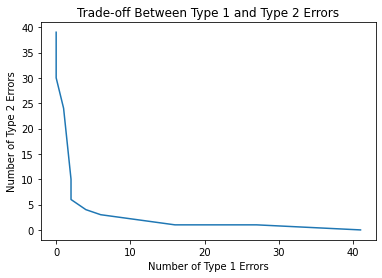

In [24]:
import os.path
import numpy as np
import matplotlib.pyplot as plt


def learn_distributions(file_lists_by_category):
    """
    Estimate the parameters p_d, and q_d from the training set
    
    Input
    -----
    file_lists_by_category: A two-element list. The first element is a list of 
    spam files, and the second element is a list of ham files.

    Output
    ------
    probabilities_by_category: A two-element tuple. The first element is a dict 
    whose keys are words, and whose values are the smoothed estimates of p_d;
    the second element is a dict whose keys are words, and whose values are the 
    smoothed estimates of q_d 
    """
    ### TODO: Write your code here

    #fetch the spam and ham dictionaries, and find the number of words
    spam_dict = get_word_freq(file_lists_by_category[0])
    spam_words = sum(spam_dict.values())
    ham_dict = get_word_freq(file_lists_by_category[1])
    ham_words = sum(ham_dict.values())
    total = get_word_freq(file_lists_by_category[0] + file_lists_by_category[1])

    for i in spam_dict:
        spam_dict[i] = (spam_dict[i] + 1) / (spam_words + len(total))

    for i in ham_dict:
        ham_dict[i] = (ham_dict[i] + 1) / (ham_words + len(total))
    
    probabilities_by_category = (spam_dict, ham_dict)

    return probabilities_by_category

def classify_new_email(filename,probabilities_by_category,prior_by_category, T):
    """
    Use Naive Bayes classification to classify the email in the given file.

    Inputs
    ------
    filename: name of the file to be classified
    probabilities_by_category: output of function learn_distributions
    prior_by_category: A two-element list as [\pi, 1-\pi], where \pi is the 
    parameter in the prior class distribution

    Output
    ------
    classify_result: A two-element tuple. The first element is a string whose value
    is either 'spam' or 'ham' depending on the classification result, and the 
    second element is a two-element list as [log p(y=1|x), log p(y=0|x)], 
    representing the log posterior probabilities
    """
    ### TODO: Write your code here
    filename = (filename, 1)
    freq = get_word_freq(filename[0:1])

    #prevent underflow
    log_spam_prior, log_ham_prior = np.log(prior_by_category[0]), np.log(prior_by_category[1])
    
    spam_likelihood = ham_likelihood = 0

    for i in freq:
        if i in probabilities_by_category[0] and i in probabilities_by_category[1]:
            spam_likelihood += np.log(probabilities_by_category[0][i] * freq[i])
            ham_likelihood += np.log(probabilities_by_category[1][i] * freq[i])
    
    log_spam_posterior, log_ham_posterior = log_spam_prior + spam_likelihood, log_ham_prior + ham_likelihood

    p = 0.5 #default value of p
    if T != 0:
        T = np.log(T)

    if(log_spam_posterior + np.log(p) >= (log_ham_posterior + np.log(1-p)) + T):
        classify_result = ('spam', [log_spam_posterior, log_ham_posterior])
    else:
        classify_result = ('ham', [log_spam_posterior, log_ham_posterior])

    return classify_result

if __name__ == '__main__':
    
    # folder for training and testing 
    spam_folder = "/content/gdrive/My Drive/ECE368/data/spam"
    ham_folder = "/content/gdrive/My Drive/ECE368/data/ham"
    test_folder = "/content/gdrive/My Drive/ECE368/data/testing"

    # generate the file lists for training
    file_lists = []
    for folder in (spam_folder, ham_folder):
        file_lists.append(get_files_in_folder(folder))
        
    # Learn the distributions    
    probabilities_by_category = learn_distributions(file_lists)
    
    # prior class distribution
    priors_by_category = [0.5, 0.5]
    
    # Store the classification results
    performance_measures = np.zeros([2,2])
    # explanation of performance_measures:
    # columns and rows are indexed by 0 = 'spam' and 1 = 'ham'
    # rows correspond to true label, columns correspond to guessed label
    # to be more clear, performance_measures = [[p1 p2]
    #                                           [p3 p4]]
    # p1 = Number of emails whose true label is 'spam' and classified as 'spam' 
    # p2 = Number of emails whose true label is 'spam' and classified as 'ham' 
    # p3 = Number of emails whose true label is 'ham' and classified as 'spam' 
    # p4 = Number of emails whose true label is 'ham' and classified as 'ham' 

    # Classify emails from testing set and measure the performance
    for filename in (get_files_in_folder(test_folder)):
        # Classify
        label,log_posterior = classify_new_email(filename,
                                                 probabilities_by_category,
                                                 priors_by_category, T=0)
        
        # Measure performance (the filename indicates the true label)
        base = os.path.basename(filename)
        true_index = ('ham' in base) 
        guessed_index = (label == 'ham')
        performance_measures[int(true_index), int(guessed_index)] += 1

    template="You correctly classified %d out of %d spam emails, and %d out of %d ham emails."
    # Correct counts are on the diagonal
    correct = np.diag(performance_measures)
    # totals are obtained by summing across guessed labels
    totals = np.sum(performance_measures, 1)
    print(template % (correct[0],totals[0],correct[1],totals[1]))
    
    
    ### TODO: Write your code here to modify the decision rule such that
    ### Type 1 and Type 2 errors can be traded off, plot the trade-off curve
    type1 = []
    type2 = []
    for T in [1e-20, 1e-10, 1e-5, 1e-2, 1e-1, 1e1, 1e2, 1e5, 1e10, 1e20]:
        # generate the file lists for training
        file_lists = []
        for folder in (spam_folder, ham_folder):
            file_lists.append(get_files_in_folder(folder))
            
        # Learn the distributions    
        probabilities_by_category = learn_distributions(file_lists)
        
        # prior class distribution
        priors_by_category = [0.5, 0.5]
        
        # Store the classification results
        performance_measures = np.zeros([2,2])
        # explanation of performance_measures:
        # columns and rows are indexed by 0 = 'spam' and 1 = 'ham'
        # rows correspond to true label, columns correspond to guessed label
        # to be more clear, performance_measures = [[p1 p2]
        #                                           [p3 p4]]
        # p1 = Number of emails whose true label is 'spam' and classified as 'spam' 
        # p2 = Number of emails whose true label is 'spam' and classified as 'ham' 
        # p3 = Number of emails whose true label is 'ham' and classified as 'spam' 
        # p4 = Number of emails whose true label is 'ham' and classified as 'ham' 

        # Classify emails from testing set and measure the performance
        for filename in (get_files_in_folder(test_folder)):
            # Classify
            label,log_posterior = classify_new_email(filename,
                                                    probabilities_by_category,
                                                    priors_by_category, T)
            
            # Measure performance (the filename indicates the true label)
            base = os.path.basename(filename)
            true_index = ('ham' in base) 
            guessed_index = (label == 'ham')
            performance_measures[int(true_index), int(guessed_index)] += 1

        template="You correctly classified %d out of %d spam emails, and %d out of %d ham emails."
        # Correct counts are on the diagonal
        correct = np.diag(performance_measures)
        # totals are obtained by summing across guessed labels
        totals = np.sum(performance_measures, 1)
        print(template % (correct[0],totals[0],correct[1],totals[1]))
        type1.append(totals[0] - correct[0])
        type2.append(totals[1] - correct[1])

    plt.plot(type1, type2)
    plt.title("Trade-off Between Type 1 and Type 2 Errors")
    plt.xlabel("Number of Type 1 Errors")
    plt.ylabel("Number of Type 2 Errors")

 